#import python packages

In [20]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import io
import nltk
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalAveragePooling1D,Flatten, Dropout , GRU
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv1D, MaxPool1D

#Read dataset as json file

In [21]:
with open("dataset/guci_intent.json") as guci_dataset:
  dataset = json.load(guci_dataset)

In [22]:
def processing_json_dataset(dataset):
  tags = []
  inputs = []
  responses={}
  for intent in dataset['intents']:
    responses[intent['intent']]=intent['responses']
    for lines in intent['text']:
      inputs.append(lines)
      tags.append(intent['intent'])
  return [tags, inputs, responses]

In [23]:
[tags, inputs, responses] = processing_json_dataset(dataset)

#dataset as DataFrame

In [24]:
dataset = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [25]:
dataset.head()

,inputs,tags
0,Assalamu'alaikum,Basic1
1,mikum,Basic1
2,ass,Basic1
3,assalamu'alaikum wr.wb,Basic1
4,.,Basic1


In [26]:
dataset = dataset.sample(frac=1)

In [27]:
dataset.head()

,inputs,tags
5,tiket masuk guci,Basic2
74,pemandian rindu alam?,lokasi10
115,hotel guci kencana?,lokasi22
44,hotel barokah?,lokasi1
26,hai,Basic7


#Pre-processing text of dataset

In [28]:
import string
dataset['inputs'] = dataset['inputs'].apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])

In [29]:
dataset.head()

,inputs,tags
5,"[t, i, k, e, t, , m, a, s, u, k, , g, u, c, i]",Basic2
74,"[p, e, m, a, n, d, i, a, n, , r, i, n, d, u, ...",lokasi10
115,"[h, o, t, e, l, , g, u, c, i, , k, e, n, c, ...",lokasi22
44,"[h, o, t, e, l, , b, a, r, o, k, a, h]",lokasi1
26,"[h, a, i]",Basic7


In [30]:
dataset['inputs'] = dataset['inputs'].apply(lambda wrd: ''.join(wrd))

In [31]:
dataset.head()

,inputs,tags
5,tiket masuk guci,Basic2
74,pemandian rindu alam,lokasi10
115,hotel guci kencana,lokasi22
44,hotel barokah,lokasi1
26,hai,Basic7


In [32]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(dataset['inputs'])
train = tokenizer.texts_to_sequences(dataset['inputs'])
features = pad_sequences(train)
le = LabelEncoder()
labels = le.fit_transform(dataset['tags'])

In [33]:
len(features[0])

6

In [61]:
input_shape = features.shape[1]
print(input_shape)

6


In [35]:
features.shape

(136, 6)

In [56]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  112
output length:  36


In [59]:
le.classes_
np.save('output/classes.npy', le.classes_)

In [37]:
tokenizer.word_index

{'guci': 1,
 'hotel': 2,
 'pemandian': 3,
 'penginapan': 4,
 'cafe': 5,
 'alam': 6,
 'wisata': 7,
 'barokah': 8,
 'hai': 9,
 'p': 10,
 'onsen': 11,
 'gulala': 12,
 'air': 13,
 'grand': 14,
 'start': 15,
 'hallo': 16,
 'mulai': 17,
 'rindu': 18,
 'kencana': 19,
 'salma': 20,
 'panas': 21,
 'fyp': 22,
 'di': 23,
 'the': 24,
 'dian': 25,
 'duta': 26,
 'mega': 27,
 'kampung': 28,
 'forest': 29,
 'water': 30,
 'boom': 31,
 'ashafana': 32,
 'sabda': 33,
 'gung': 34,
 'spot': 35,
 'foto': 36,
 'ta': 37,
 'rawamba': 38,
 'tiket': 39,
 'rekomendasi': 40,
 'assalamualaikum': 41,
 'geong': 42,
 'gran': 43,
 'bagaimana': 44,
 'cod': 45,
 'joglo': 46,
 'ageng': 47,
 'serwiti': 48,
 'tempat': 49,
 'kafe': 50,
 'guciku': 51,
 'sun': 52,
 'q': 53,
 'masuk': 54,
 'azana': 55,
 'ig': 56,
 'ass': 57,
 'wrwb': 58,
 'termewah': 59,
 'graha': 60,
 'tirta': 61,
 'ayu': 62,
 'shtepine': 63,
 'hari': 64,
 'ini': 65,
 'terjun': 66,
 'prosotan': 67,
 'warna': 68,
 'warni': 69,
 'cukup': 70,
 'gbugs': 71,
 'shelt

#RNN MODEL

## Build RNN Model

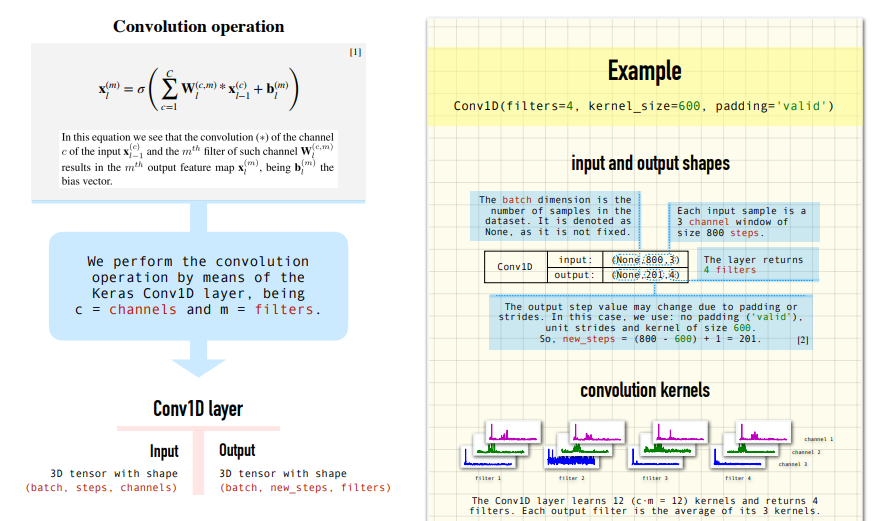

In [38]:
m = Sequential()
m.add(Input(shape=(features.shape[1],)))
m.add(Embedding(vocabulary + 1,50))
m.add(Conv1D(filters=32, kernel_size=2, activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_regularizer=tf.keras.regularizers.L2(0.0001), kernel_regularizer=tf.keras.regularizers.L2(0.0001), activity_regularizer = tf.keras.regularizers.L2(0.0001))) 
m.add(Dropout(0.3))
m.add(LSTM(32, dropout=0.3,return_sequences=True))
m.add(LSTM(16, dropout=0.3,return_sequences=False))
m.add(Dense(128,activation="relu", activity_regularizer = tf.keras.regularizers.L2(0.0001))) 
m.add(Dropout(0.6))
m.add(Dense(output_length, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.0001)))

In [39]:
m.layers

In [40]:
glove_dir = "glove/glove_50dim_wiki.id.case.text.txt"
embeddings_index = {}
file_ = open(glove_dir, encoding="utf8")
for line in file_:
    arr = line.split()
    single_word = arr[0]
    w = np.asarray(arr[1:],dtype='float32')
    embeddings_index[single_word] = w
file_.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 370013 word vectors.


In [41]:
max_words = vocabulary + 1
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words,50)).astype(object)
for word , i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [42]:
m.layers[0].set_weights([embedding_matrix])
m.layers[0].trainable = False

In [43]:
m.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [44]:
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 6, 50)             5650      
                                                                 
 conv1d (Conv1D)             (None, 5, 32)             3232      
                                                                 
 dropout (Dropout)           (None, 5, 32)             0         
                                                                 
 lstm (LSTM)                 (None, 5, 32)             8320      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 128)               2176      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [45]:
from keras.callbacks import TensorBoard, EarlyStopping
earlyStopping = EarlyStopping(monitor = 'loss', patience = 400, mode = 'min', restore_best_weights = True)

In [46]:
history_training = m.fit(features,labels,epochs=2000, batch_size=64, callbacks=[ earlyStopping])

Epoch 1/2000
3/3 [==============================] - 36s 133ms/step - loss: 3.5879 - accuracy: 0.0221
Epoch 2/2000
3/3 [==============================] - 0s 78ms/step - loss: 3.5902 - accuracy: 0.0147
Epoch 3/2000
3/3 [==============================] - 0s 95ms/step - loss: 3.5876 - accuracy: 0.0368
Epoch 4/2000
3/3 [==============================] - 0s 46ms/step - loss: 3.5806 - accuracy: 0.0662
Epoch 5/2000
3/3 [==============================] - 0s 101ms/step - loss: 3.5806 - accuracy: 0.0588
Epoch 6/2000
3/3 [==============================] - 0s 72ms/step - loss: 3.5802 - accuracy: 0.0882
Epoch 7/2000
3/3 [==============================] - 0s 84ms/step - loss: 3.5839 - accuracy: 0.0515
Epoch 8/2000
3/3 [==============================] - 0s 71ms/step - loss: 3.5807 - accuracy: 0.0588
Epoch 9/2000
3/3 [==============================] - 0s 32ms/step - loss: 3.5823 - accuracy: 0.0368
Epoch 10/2000
3/3 [==============================] - 0s 71ms/step - loss: 3.5794 - accuracy: 0.0368
Epoch 

In [47]:
import matplotlib as mpl
def draw_plot(data, type_data):
  # mpl.style.use('seaborn')
  plt.figure(figsize = (25, 5))
  plt.plot(data,'darkorange', label='Train')
  plt.xlabel('Epoch')
  plt.ylabel(type_data)
  plt.legend()

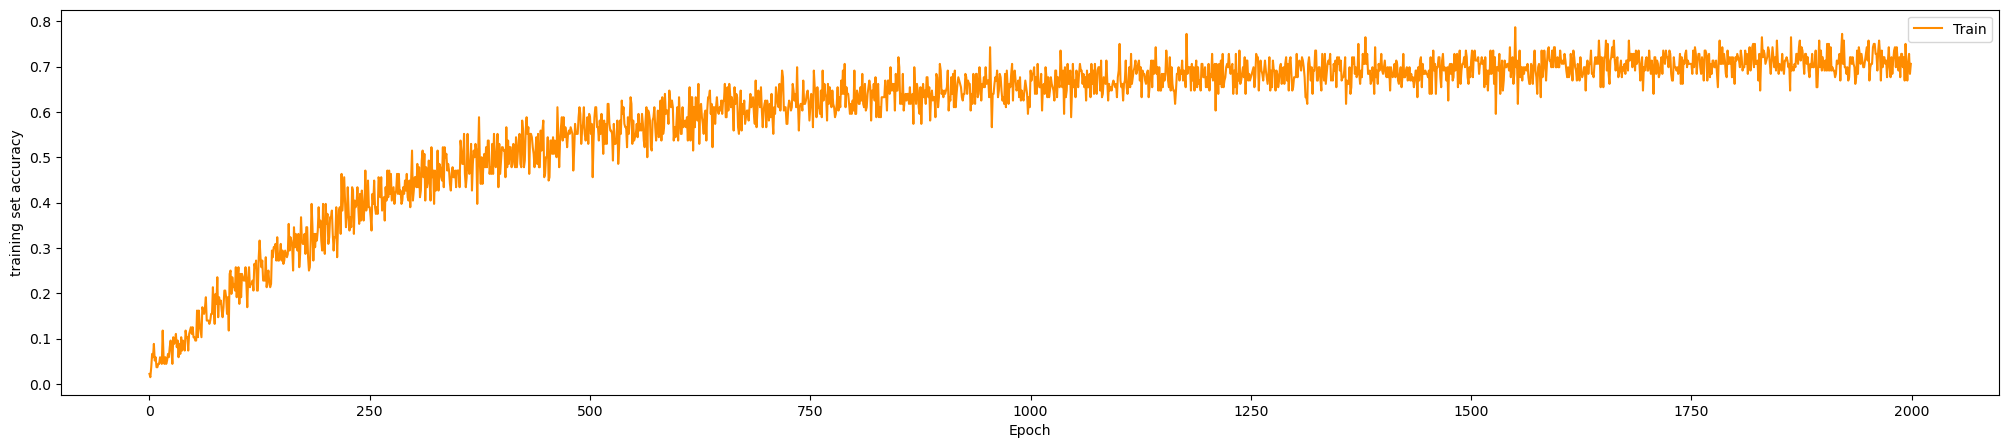

In [48]:
draw_plot(history_training.history['accuracy'],'training set accuracy' )

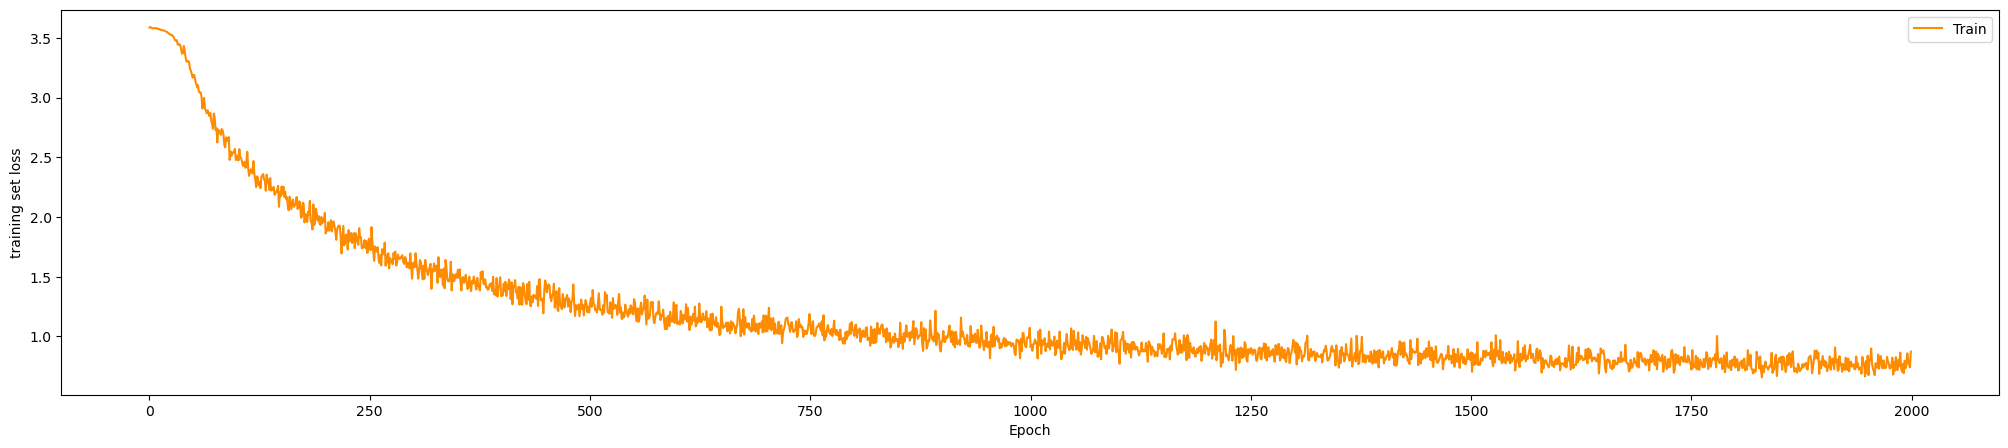

In [49]:
draw_plot(history_training.history['loss'],'training set loss' )

In [55]:
m.evaluate(features, labels, batch_size = 64)
m.save("output/guci.keras")

3/3 [==============================] - 1s 17ms/step - loss: 0.5712 - accuracy: 0.7647


#Live Testing

In [51]:
import random
def generate_answer(query):
  texts = []
  pred_input = query
  pred_input = [letters.lower() for letters in pred_input if letters not in string.punctuation]
  pred_input = ''.join(pred_input)
  texts.append(pred_input)
  pred_input = tokenizer.texts_to_sequences(texts)
  pred_input = np.array(pred_input).reshape(-1)
  pred_input = pad_sequences([pred_input],input_shape)
  output = m.predict(pred_input)
  output = output.argmax()
  response_tag = le.inverse_transform([output])[0]
  return random.choice(responses[response_tag])

In [52]:
list_que = ["fyp tiktok guci", "hotel the onsen?"]
for i in list_que:
  print("you: {}".format(i))
  res_tag = generate_answer(i)
  print(res_tag)  

you: fyp tiktok guci
1/1 [==============================] - 6s 6s/step
Anda dapat mengunjungi <HOTEL> dengan detail sebagai berikut ini :
you: hotel the onsen?
1/1 [==============================] - 1s 650ms/step
Anda dapat mengunjungi <WISATA> dengan detail sebagai berikut ini :


In [60]:
encoder = LabelEncoder()
encoder.classes_ = np.load('output/classes.npy', allow_pickle=True)
print(encoder.classes_)

new_model = tf.keras.models.load_model('output/guci.keras')
new_model.summary()

['Basic1' 'Basic2' 'Basic3' 'Basic4' 'Basic5' 'Basic6' 'Basic7' 'Basic8'
 'Basic9' 'lokasi1' 'lokasi10' 'lokasi11' 'lokasi12' 'lokasi13' 'lokasi14'
 'lokasi15' 'lokasi16' 'lokasi17' 'lokasi18' 'lokasi19' 'lokasi2'
 'lokasi20' 'lokasi21' 'lokasi22' 'lokasi23' 'lokasi24' 'lokasi25'
 'lokasi26' 'lokasi27' 'lokasi3' 'lokasi4' 'lokasi5' 'lokasi6' 'lokasi7'
 'lokasi8' 'lokasi9']


In [54]:
import pickle

# saving
with open('output/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('output/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)